# TP3, INF8225 2025, Machine translation

This TP will be due on March 27th at 8:30am.
The goal of this TP is to build a machine translation model.
You will be comparing the performance of three different architectures:
* A Vanilla RNN (**Implementation provided!**)
* A GRU-RNN (done individually)
* A Transformer (The implementation, testing and experiments with an Encoder-Decoder - done individually, but you may discuss how to do this, ideas for experiments, etc. with any of your colleagues)

You are provided with the code to load and build the pytorch dataset, the implementation for the Vanilla RNN architecture
and the code for the training loop.
You "only" have to code the architectures (a GRU-RNN and a the missing parts of the Encoder-Decoder Transformer).
Of course, the use of built-in torch layers such as `nn.GRU` or `nn.Transformer`
is forbidden, as the TP would be much easier and you would learn much less.

The source sentences are in english and the target language is french.

We hope that this TP also provides you with a basic but realistic machine learning pipeline. We hope you learn a lot from the provided code.

Do not forget to **select the runtime type as GPU!**

**Sources**

* Dataset: [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

<!---
M. Cettolo, C. Girardi, and M. Federico. 2012. WIT3: Web Inventory of Transcribed and Translated Talks. In Proc. of EAMT, pp. 261-268, Trento, Italy. pdf, bib. [paper](https://aclanthology.org/2012.eamt-1.60.pdf). [website](https://wit3.fbk.eu/2016-01).
-->

* The code is inspired by this [pytorch tutorial](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html).

*This notebook is quite big, use the table of contents to easily navigate through it.*

# Imports and data initializations

We first download and parse the dataset. From the parsed sentences
we can build the vocabularies and the torch datasets.
The end goal of this section is to have an iterator
that can yield the pairs of translated datasets, and
where each sentences is made of a sequence of tokens.

## Imports

In [ ]:
# Note current default torch and cuda was 2.6.0+cu124
# We need to go back to an earlier version compatible with torchtext
# This will generate some dependency issues (incompatible packages), but for things that we will not need for this TP

!pip install torch==2.1.2+cu121 -f https://download.pytorch.org/whl/torch/ --force-reinstall --no-cache-dir
!pip install torchtext==0.16.2 --force-reinstall --no-cache-dir
!pip install numpy==1.23.5 --force-reinstall --no-cache-dir

!pip install scikit-learn==1.1.3 --force-reinstall --no-cache-dir
!pip install scipy==1.9.3 --force-reinstall --no-cache-dir

!pip install spacy einops wandb torchinfo pandas
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

Looking in links: https://download.pytorch.org/whl/torch/
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 32.3 MB/s eta 0:01:17
     ---------------------------------------- 0.0/2.5 GB 31.6 MB/s eta 0:01:18
     ---------------------------------------- 0.0/2.5 GB 31.9 MB/s eta 0:01:18
     ---------------------------------------- 0.0/2.5 GB 34.5 MB/s eta 0:01:11
      --------------------------------------- 0.0/2.5 GB 34.1 MB/s eta 0:01:12
      --------------------------------------- 0.0/2.5 GB 34.6 MB/s eta 0:01:11
      --------------------------------------- 0.1/2.5 GB 35.6 MB/s eta 0:01:09
      --------------------------------------- 0.1/2.5 GB 35.1 MB/s eta 0:01:09
     - -------------------------------------- 0.1/2.5 GB 34.8 MB/s eta 0:01:10
     - -------------------------------------- 0.1/2.5 GB 35.1 MB/s eta 0:01:09
     - -------------------------------------- 0.1/2.5 GB 35.9 MB/s eta 0:01:07
  

  You can safely remove it manually.


   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   --------------- ------------------------ 5.8/14.6 MB 32.0 MB/s eta 0:00:01
   ------------------------------------ --- 13.4/14.6 MB 36.4 MB/s eta 0:00:01
   ---------------------------------------- 14.6/14.6 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   --------------------------------- ------ 6.3/7.5 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 33.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ----------------------- ---------------- 7.6/12.9 MB 36.2 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 33.8 MB/s eta 0:00:00
   ---------------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


   ---------------------------------------- 0.0/39.9 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/39.9 MB 28.6 MB/s eta 0:00:02
   ----------- ---------------------------- 11.0/39.9 MB 29.9 MB/s eta 0:00:01
   ------------------ --------------------- 18.9/39.9 MB 33.1 MB/s eta 0:00:01
   -------------------------- ------------- 26.0/39.9 MB 32.9 MB/s eta 0:00:01
   --------------------------------- ------ 33.6/39.9 MB 33.8 MB/s eta 0:00:01
   ---------------------------------------- 39.9/39.9 MB 34.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ------------------ --------------------- 7.1/15.5 MB 33.6 MB/s eta 0:00:01
   ----------------------------------- ---- 13.9/15.5 MB 33.5 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  A

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [ ]:
from itertools import takewhile
from collections import Counter, defaultdict

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
# cpal
print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torchtext.datasets import IWSLT2016

import spacy
import einops
import wandb
from torchinfo import summary

import math

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

2.1.2+cu121
cuda


In [ ]:
# Our dataset
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

df = pd.read_csv('fra.txt', sep='\t', names=['english', 'french', 'attribution'])
train = [
    (en, fr) for en, fr in zip(df['english'], df['french'])
]
train, valid = train_test_split(train, test_size=0.1, random_state=0)
print(len(train))

en_nlp = spacy.load('en_core_web_sm')
fr_nlp = spacy.load('fr_core_news_sm')

def en_tokenizer(text):
    return [tok.text.lower() for tok in en_nlp.tokenizer(text)]
def fr_tokenizer(text):
    return [tok.text.lower() for tok in fr_nlp.tokenizer(text)]

SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

--2025-03-22 23:49:17--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  20.8MB/s    in 0.4s    

2025-03-22 23:49:18 (20.8 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
209462


The tokenizers are objects that are able to divide a python string into a list of tokens (words, punctuations, special tokens...) as a list of strings.

The special tokens are used for a particular reasons:
* *\<unk\>*: Replace an unknown word in the vocabulary by this default token
* *\<pad\>*: Virtual token used to as padding token so a batch of sentences can have a unique length
* *\<bos\>*: Token indicating the beggining of a sentence in the target sequence
* *\<eos\>*: Token indicating the end of a sentence in the target sequence

## Datasets

Functions and classes to build the vocabularies and the torch datasets.
The vocabulary is an object able to transform a string token into the id (an int) of that token in the vocabulary.

In [ ]:
class TranslationDataset(Dataset):
    def __init__(
            self,
            dataset: list,
            en_vocab: Vocab,
            fr_vocab: Vocab,
            en_tokenizer,
            fr_tokenizer,
        ):
        super().__init__()

        self.dataset = dataset
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        self.en_tokenizer = en_tokenizer
        self.fr_tokenizer = fr_tokenizer

    def __len__(self):
        """Return the number of examples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> tuple:
        """Return a sample.

        Args
        ----
            index: Index of the sample.

        Output
        ------
            en_tokens: English tokens of the sample, as a LongTensor.
            fr_tokens: French tokens of the sample, as a LongTensor.
        """
        # Get the strings
        en_sentence, fr_sentence = self.dataset[index]

        # To list of words
        # We also add the beggining-of-sentence and end-of-sentence tokens
        en_tokens = ['<bos>'] + self.en_tokenizer(en_sentence) + ['<eos>']
        fr_tokens = ['<bos>'] + self.fr_tokenizer(fr_sentence) + ['<eos>']

        # To list of tokens
        en_tokens = self.en_vocab(en_tokens)  # list[int]
        fr_tokens = self.fr_vocab(fr_tokens)

        return torch.LongTensor(en_tokens), torch.LongTensor(fr_tokens)


def yield_tokens(dataset, tokenizer, lang):
    """Tokenize the whole dataset and yield the tokens.
    """
    assert lang in ('en', 'fr')
    sentence_idx = 0 if lang == 'en' else 1

    for sentences in dataset:
        sentence = sentences[sentence_idx]
        tokens = tokenizer(sentence)
        yield tokens


def build_vocab(dataset: list, en_tokenizer, fr_tokenizer, min_freq: int):
    """Return two vocabularies, one for each language.
    """
    en_vocab = build_vocab_from_iterator(
        yield_tokens(dataset, en_tokenizer, 'en'),
        min_freq=min_freq,
        specials=SPECIALS,
    )
    en_vocab.set_default_index(en_vocab['<unk>'])  # Default token for unknown words

    fr_vocab = build_vocab_from_iterator(
        yield_tokens(dataset, fr_tokenizer, 'fr'),
        min_freq=min_freq,
        specials=SPECIALS,
    )
    fr_vocab.set_default_index(fr_vocab['<unk>'])

    return en_vocab, fr_vocab


def preprocess(
        dataset: list,
        en_tokenizer,
        fr_tokenizer,
        max_words: int,
    ) -> list:
    """Preprocess the dataset.
    Remove samples where at least one of the sentences are too long.
    Those samples takes too much memory.
    Also remove the pending '\n' at the end of sentences.
    """
    filtered = []

    for en_s, fr_s in dataset:
        if len(en_tokenizer(en_s)) >= max_words or len(fr_tokenizer(fr_s)) >= max_words:
            continue

        en_s = en_s.replace('\n', '')
        fr_s = fr_s.replace('\n', '')

        filtered.append((en_s, fr_s))

    return filtered


def build_datasets(
        max_sequence_length: int,
        min_token_freq: int,
        en_tokenizer,
        fr_tokenizer,
        train: list,
        val: list,
    ) -> tuple:
    """Build the training, validation and testing datasets.
    It takes care of the vocabulary creation.

    Args
    ----
        - max_sequence_length: Maximum number of tokens in each sequences.
            Having big sequences increases dramatically the VRAM taken during training.
        - min_token_freq: Minimum number of occurences each token must have
            to be saved in the vocabulary. Reducing this number increases
            the vocabularies's size.
        - en_tokenizer: Tokenizer for the english sentences.
        - fr_tokenizer: Tokenizer for the french sentences.
        - train and val: List containing the pairs (english, french) sentences.


    Output
    ------
        - (train_dataset, val_dataset): Tuple of the two TranslationDataset objects.
    """
    datasets = [
        preprocess(samples, en_tokenizer, fr_tokenizer, max_sequence_length)
        for samples in [train, val]
    ]

    en_vocab, fr_vocab = build_vocab(datasets[0], en_tokenizer, fr_tokenizer, min_token_freq)

    datasets = [
        TranslationDataset(samples, en_vocab, fr_vocab, en_tokenizer, fr_tokenizer)
        for samples in datasets
    ]

    return datasets


In [ ]:
def generate_batch(data_batch: list, src_pad_idx: int, tgt_pad_idx: int) -> tuple:
    """Add padding to the given batch so that all
    the samples are of the same size.

    Args
    ----
        data_batch: List of samples.
            Each sample is a tuple of LongTensors of varying size.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.

    Output
    ------
        en_batch: Batch of tokens for the padded english sentences.
            Shape of [batch_size, max_en_len].
        fr_batch: Batch of tokens for the padded french sentences.
            Shape of [batch_size, max_fr_len].
    """
    en_batch, fr_batch = [], []
    for en_tokens, fr_tokens in data_batch:
        en_batch.append(en_tokens)
        fr_batch.append(fr_tokens)

    en_batch = pad_sequence(en_batch, padding_value=src_pad_idx, batch_first=True)
    fr_batch = pad_sequence(fr_batch, padding_value=tgt_pad_idx, batch_first=True)
    return en_batch, fr_batch

# Models architecture
This is where you have to code the architectures.

In a machine translation task, the model takes as input the whole
source sentence along with the current known tokens of the target,
and predict the next token in the target sequence.
This means that the target tokens are predicted in an autoregressive
manner, starting from the first token (right after the *\<bos\>* token) and producing tokens one by one until the last *\<eos\>* token.

Formally, we define $s = [s_1, ..., s_{N_s}]$ as the source sequence made of $N_s$ tokens.
We also define $t^i = [t_1, ..., t_i]$ as the target sequence at the beginning of the step $i$.

The output of the model parameterized by $\theta$ is:

$$
T_{i+1} = p(t_{i+1} | s, t^i ; \theta )
$$

Where $T_{i+1}$ is the distribution of the next token $t_{i+1}$.

The loss is simply a *cross entropy loss* over the whole steps, where each class is a token of the vocabulary.

![RNN schema for machinea translation](https://www.simplilearn.com/ice9/free_resources_article_thumb/machine-translation-model-with-encoder-decoder-rnn.jpg)

Note that in this image the english sentence is provided in reverse.

---

In pytorch, there is no dinstinction between an intermediate layer or a whole model having multiple layers in itself.
Every layers or models inherit from the `torch.nn.Module`.
This module needs to define the `__init__` method where you instanciate the layers,
and the `forward` method where you decide how the inputs and the layers of the module interact between them.
Thanks to the autograd computations of pytorch, you do not have
to implement any backward method!

A really important advice is to **always look at
the shape of your input and your output.**
From that, you can often guess how the layers should interact
with the inputs to produce the right output.
You can also easily detect if there's something wrong going on.

You are more than advised to use the `einops` library and the `torch.einsum` function. This will require less operations than 'classical' code, but note that it's a bit trickier to use.
This is a way of describing tensors manipulation with strings, bypassing the multiple tensor methods executed in the background.
You can find a nice presentation of `einops` [here](https://einops.rocks/1-einops-basics/).
A paper has just been released about einops [here](https://paperswithcode.com/paper/einops-clear-and-reliable-tensor).

**A great tutorial on pytorch can be found [here](https://stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html).**
Spending 3 hours on this tutorial is *no* waste of time.

## RNN models

### RNN
Here, the implementation of the RNN is provided as an example. Study this code and use it as an example for the GRU implementation, if needed.

The `RNNCell` layer produce one hidden state vector for each sentence in the batch
(useful for the output of the encoder), and also produce one embedding for each
token in each sentence (useful for the output of the decoder).

The `RNN` module is composed of a stack of `RNNCell`. Each token embeddings
coming out from a previous `RNNCell` is used as an input for the next `RNNCell` layer.

**Be careful !** Our `RNNCell` implementation is not exactly the same thing as
the PyTorch's `nn.RNNCell`. PyTorch implements only the operations for one token
(so you would need to loop through each tokens inside the `RNN` instead).

The same thing apply for the `GRU` and `GRUCell`.


In [ ]:
class RNNCell(nn.Module):
    """A single RNN layer.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        dropout: Dropout rate.

    Important note: This layer does not exactly the same thing as nn.RNNCell does.
    PyTorch implementation is only doing one simple pass over one token for each batch.
    This implementation is taking the whole sequence of each batch and provide the
    final hidden state along with the embeddings of each token in each sequence.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            dropout: float,
        ):
        super().__init__()

        self.hidden_size = hidden_size

        # See pytorch definition: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.Wih = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Whh = nn.Linear(hidden_size, hidden_size, device=DEVICE)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.Tanh()

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor) -> tuple:
        """Go through all the sequence in x, iteratively updating
        the hidden state h.

        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state.
                Shape of [batch_size, hidden_size].

        Output
        ------
            y: Token embeddings.
                Shape of [batch_size, seq_len, hidden_size].
            h: Last hidden state.
                Shape of [batch_size, hidden_size].
        """
        batch_size, seq_len, input_size = x.shape
        y = torch.zeros([batch_size, seq_len, self.hidden_size], device=DEVICE)

        for t in range(seq_len):
          input = x[:, t, :]
          w_input = self.Wih(input)
          w_hidden = self.Whh(h)
          h = self.act(w_input + w_hidden)
          y[:, t, :] = self.dropout(h)

        return y, h


class RNN(nn.Module):
    """Implementation of an RNN based
    on https://pytorch.org/docs/stable/generated/torch.nn.RNN.html.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        num_layers: Number of layers (RNNCell or GRUCell).
        dropout: Dropout rate.
        model_type: Either 'RNN' or 'GRU', to select which model we want.
            This parameter can be removed if you decide to use the module `GRU`.
            Indeed, `GRU` should have exactly the same code as this module,
            but with `GRUCell` instead of `RNNCell`. We let the freedom for you
            to decide at which level you want to specialise the modules (either
            in `TranslationRNN` by creating a `GRU` or a `RNN`, or in `RNN`
            by creating a `GRUCell` or a `RNNCell`).
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            num_layers: int,
            dropout: float,
            model_type: str,
        ):
        super().__init__()

        self.hidden_size = hidden_size
        model_class = RNNCell if model_type == 'RNN' else GRUCell

        self.layers = nn.ModuleList()
        self.layers.append(model_class(input_size, hidden_size, dropout))
        for i in range(1, num_layers):
          self.layers.append(model_class(hidden_size, hidden_size, dropout))

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor=None) -> tuple:
        """Pass the input sequence through all the RNN cells.
        Returns the output and the final hidden state of each RNN layer

        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Hidden state for each RNN layer.
                Can be None, in which case an initial hidden state is created.
                Shape of [batch_size, n_layers, hidden_size].

        Output
        ------
            y: Output embeddings for each token after the RNN layers.
                Shape of [batch_size, seq_len, hidden_size].
            h: Final hidden state.
                Shape of [batch_size, n_layers, hidden_size].
        """
        input = x
        h = torch.zeros([x.shape[0], len(self.layers), self.hidden_size], device=x.device) if h is None else h
        final_h = torch.zeros_like(h, device=x.device)
        for l in range(len(self.layers)):
          input, h_out = self.layers[l](input, h[:, l, :])
          final_h[:, l, :] = h_out

        return input, final_h

### GRU
Here you have to implement a GRU-RNN. This architecture is close to the Vanilla RNN but perform different operations. Look up the pytorch documentation to figure out the differences.

In [ ]:
class GRU(nn.Module):
	"""Implementation of a GRU based on https://pytorch.org/docs/stable/generated/torch.nn.GRU.html.

	Parameters
	----------
		input_size: Size of each input token.
		hidden_size: Size of each RNN hidden state.
		num_layers: Number of layers.
		dropout: Dropout rate.
	"""
	def __init__(
			self,
			input_size: int,
			hidden_size: int,
			num_layers: int,
			dropout: float,
		):
		super().__init__()

		self.hidden_size = hidden_size
		self.layers = nn.ModuleList()
		self.layers.append(GRUCell(input_size, hidden_size, dropout))
		for i in range(1, num_layers):
			self.layers.append(GRUCell(hidden_size, hidden_size, dropout))

		self.dropout = nn.Dropout(dropout)


	def forward(self, x: torch.FloatTensor, h: torch.FloatTensor=None) -> tuple:
		"""
		Args
		----
			x: Input sequence
				Shape of [batch_size, seq_len, input_size].
			h: Initial hidden state for each layer.
				If 'None', then an initial hidden state (a zero filled tensor)
				is created.
				Shape of [batch_size, n_layers, hidden_size].

		Output
		------
			output:
				Shape of [batch_size, seq_len, hidden_size].
			h_n: Final hidden state.
				Shape of [batch_size, n_layers, hidden size].
		"""
		input = x
		h = torch.zeros([x.shape[0], len(self.layers), self.hidden_size], device=x.device) if h is None else h
		final_h = torch.zeros_like(h, device=x.device)
		for l in range(len(self.layers)):
			input, h_out = self.layers[l](input, h[:, l, :])
			final_h[:, l, :] = h_out

		return input, final_h


class GRUCell(nn.Module):
	"""A single GRU layer.

	Parameters
	----------
		input_size: Size of each input token.
		hidden_size: Size of each RNN hidden state.
		dropout: Dropout rate.
	"""
	def __init__(
			self,
			input_size: int,
			hidden_size: int,
			dropout: float,
		):
		super().__init__()

		self.hidden_size = hidden_size

		self.W_ir = nn.Linear(input_size, hidden_size, device=DEVICE)
		self.W_hr = nn.Linear(hidden_size, hidden_size, device=DEVICE)

		self.W_iz = nn.Linear(input_size, hidden_size, device=DEVICE)
		self.W_hz = nn.Linear(hidden_size, hidden_size, device=DEVICE)

		self.W_in = nn.Linear(input_size, hidden_size, device=DEVICE)
		self.W_hn = nn.Linear(hidden_size, hidden_size, device=DEVICE)

		self.act_sig = nn.Sigmoid()
		self.act_tanh = nn.Tanh()
		self.dropout = nn.Dropout(dropout)


	def forward(self, x: torch.FloatTensor, h: torch.FloatTensor) -> tuple:
		"""
		Args
		----
			x: Input sequence.
				Shape of [batch_size, seq_len, input_size].
			h: Initial hidden state.
				Shape of [batch_size, hidden_size].

		Output
		------
			y: Token embeddings.
				Shape of [batch_size, seq_len, hidden_size].
			h: Last hidden state.
				Shape of [batch_size, hidden_size].
		"""
		batch_size, seq_len, _ = x.shape
		y = torch.zeros([batch_size, seq_len, self.hidden_size], device=DEVICE)

		for t in range(seq_len):
			input = x[:, t, :]

			r = self.act_sig(self.W_ir(input) + self.W_hr(h))
			z = self.act_sig(self.W_iz(input) + self.W_hz(h))
			n = self.act_tanh(self.W_in(input) + r * self.W_hn(h))

			h = (1 - z) * n + z * h
			y[:, t, :] = self.dropout(h)

		return y, h

### Translation RNN

This module instanciates a vanilla RNN or a GRU-RNN and performs the translation task. This code des the following:
* Encodes the source and target sequence
* Passes the final hidden state of the encoder to the decoder (one for each layer)
* Decodes the hidden state into the target sequence

We use teacher forcing for training, meaning that when the next token is predicted, that prediction is based on the previous true target tokens.

In [ ]:
class TranslationRNN(nn.Module):
    """Basic RNN encoder and decoder for a translation task.
    It can run as a vanilla RNN or a GRU-RNN.

    Parameters
    ----------
        n_tokens_src: Number of tokens in the source vocabulary.
        n_tokens_tgt: Number of tokens in the target vocabulary.
        dim_embedding: Dimension size of the word embeddings (for both language).
        dim_hidden: Dimension size of the hidden layers in the RNNs
            (for both the encoder and the decoder).
        n_layers: Number of layers in the RNNs.
        dropout: Dropout rate.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.
        model_type: Either 'RNN' or 'GRU', to select which model we want.
    """

    def __init__(
            self,
            n_tokens_src: int,
            n_tokens_tgt: int,
            dim_embedding: int,
            dim_hidden: int,
            n_layers: int,
            dropout: float,
            src_pad_idx: int,
            tgt_pad_idx: int,
            model_type: str,
        ):
        super().__init__()
        self.src_embeddings = nn.Embedding(n_tokens_src, dim_embedding, src_pad_idx)
        self.tgt_embeddings = nn.Embedding(n_tokens_tgt, dim_embedding, tgt_pad_idx)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

        self.encoder = RNN(dim_embedding, dim_hidden, n_layers, dropout, model_type)
        self.norm = nn.LayerNorm(dim_hidden)
        self.decoder = RNN(dim_embedding, dim_hidden, n_layers, dropout, model_type)
        self.out_layer = nn.Linear(dim_hidden, n_tokens_tgt)


    def forward(
        self,
        source: torch.LongTensor,
        target: torch.LongTensor
    ) -> torch.FloatTensor:
        """Predict the target tokens logits based on the source tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, src_seq_len].
            target: Batch of target sentences.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y: Distributions over the next token for all tokens in each sentences.
                Those need to be the logits only, do not apply a softmax because
                it will be done in the loss computation for numerical stability.
                See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more informations.
                Shape of [batch_size, tgt_seq_len, n_tokens_tgt].
        """
        source = torch.fliplr(source)

        src_emb = self.src_embeddings(source)
        out, hidden = self.encoder(src_emb)

        hidden = self.norm(hidden)

        tgt_emb = self.tgt_embeddings(target)
        y, hidden = self.decoder(tgt_emb, hidden)

        y = self.out_layer(y)

        return y


## Transformer models
Here you have to code the Full Transformer and Decoder-Only Transformer architectures.
It is divided in three parts:
* Attention layers (done individually)
* Encoder and decoder layers (done individually)
* Full Transformer: gather the encoder and decoder layers (done individually)

The Transformer (or "Full Transformer") is presented in the paper: [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). The [illustrated transformer](https://jalammar.github.io/illustrated-transformer/) blog can help you
understanding how the architecture works.
Once this is done, you can use [the annontated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) to have an idea of how to code this architecture.
We encourage you to use `torch.einsum` and the `einops` library as much as you can. It will make your code simpler.

---
**Implementation order**

To help you with the implementation, we advise you following this order:
* Implement `TranslationTransformer` and use `nn.Transformer` instead of `Transformer`
* Implement `Transformer` and use `nn.TransformerDecoder` and `nn.TransformerEnocder`
* Implement the `TransformerDecoder` and `TransformerEncoder` and use `nn.MultiHeadAttention`
* Implement `MultiHeadAttention`

Do not forget to add `batch_first=True` when necessary in the `nn` modules.

### Positional Encoding


In [ ]:
class PositionalEncoding(nn.Module):
    """
    This PE module comes from:
    Pytorch. (2021). LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT. https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    def __init__(self, d_model: int, dropout: float, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1).to(DEVICE)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)).to(DEVICE)
        pe = torch.zeros(max_len, 1, d_model).to(DEVICE)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = einops.rearrange(x, "b s e -> s b e")
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        x = einops.rearrange(x, "s b e -> b s e")
        return self.dropout(x)

### Attention layers
We use a `MultiHeadAttention` module, that is able to perform self-attention aswell as cross-attention (depending on what you give as queries, keys and values).

**Attention**


It takes the multiheaded queries, keys and values as input.
It computes the attention between the queries and the keys and return the attended values.

The implementation of this function can greatly be improved with *einsums*.

**MultiheadAttention**

Computes the multihead queries, keys and values and feed them to the `attention` function.
You also need to merge the key padding mask and the attention mask into one mask.

The implementation of this module can greatly be improved with *einops.rearrange*.

In [ ]:
def attention(
		q: torch.FloatTensor,
		k: torch.FloatTensor,
		v: torch.FloatTensor,
		mask: torch.BoolTensor=None,
		dropout: nn.Dropout=None,
	) -> tuple:
	"""Computes multihead scaled dot-product attention from the
	projected queries, keys and values.

	Args
	----
		q: Batch of queries.
			Shape of [batch_size, seq_len_1, n_heads, dim_model].
		k: Batch of keys.
			Shape of [batch_size, seq_len_2, n_heads, dim_model].
		v: Batch of values.
			Shape of [batch_size, seq_len_2, n_heads, dim_model].
		mask: Prevent tokens to attend to some other tokens (for padding or autoregressive attention).
			Attention is prevented where the mask is `True`.
			Shape of [batch_size, n_heads, seq_len_1, seq_len_2],
			or broadcastable to that shape.
		dropout: Dropout layer to use.

	Output
	------
		y: Multihead scaled dot-attention between the queries, keys and values.
			Shape of [batch_size, seq_len_1, n_heads, dim_model].
		attn: Computed attention between the keys and the queries.
			Shape of [batch_size, n_heads, seq_len_1, seq_len_2].
	"""
	attn = torch.einsum("bihd,bjhd->bhij", [q, k]) / np.sqrt(k.shape[-1])

	if mask is not None:
		attn.masked_fill_(mask, float('-inf'))

	attn = torch.softmax(attn, dim=-1)
	d_attn = attn

	if dropout is not None:
		d_attn = dropout(d_attn)

	y = torch.einsum('bhij,bjhd->bihd', [d_attn, v])
	return y, attn


class MultiheadAttention(nn.Module):
	"""Multihead attention module.
	Can be used as a self-attention and cross-attention layer.
	The queries, keys and values are projected into multiple heads
	before computing the attention between those tensors.

	Parameters
	----------
		dim: Dimension of the input tokens.
		n_heads: Number of heads. `dim` must be divisible by `n_heads`.
		dropout: Dropout rate.
	"""
	def __init__(
			self,
			dim: int,
			n_heads: int,
			dropout: float,
		):
		super().__init__()

		assert dim % n_heads == 0

		self.d_model = dim

		self.h = n_heads
		self.d_v = self.d_model // self.h
		self.d_k = self.d_v

		self.W_q = nn.Linear(self.d_model, self.d_model, bias=False)
		self.W_k = nn.Linear(self.d_model, self.d_model, bias=False)
		self.W_v = nn.Linear(self.d_model, self.d_model, bias=False)
		self.W_o = nn.Linear(self.h * self.d_v, self.d_model, bias=False)

		self.dropout = nn.Dropout(dropout)

	def forward(
			self,
			q: torch.FloatTensor,
			k: torch.FloatTensor,
			v: torch.FloatTensor,
			key_padding_mask: torch.BoolTensor = None,
			attn_mask: torch.BoolTensor = None,
		) -> torch.FloatTensor:
		"""Computes the scaled multi-head attention form the input queries,
		keys and values.

		Project those queries, keys and values before feeding them
		to the `attention` function.

		The masks are boolean masks. Tokens are prevented to attends to
		positions where the mask is `True`.

		Args
		----
			q: Batch of queries.
				Shape of [batch_size, seq_len_1, dim_model].
			k: Batch of keys.
				Shape of [batch_size, seq_len_2, dim_model].
			v: Batch of values.
				Shape of [batch_size, seq_len_2, dim_model].
			key_padding_mask: Prevent attending to padding tokens.
				Shape of [batch_size, seq_len_2].
			attn_mask: Prevent attending to subsequent tokens.
				Shape of [seq_len_1, seq_len_2].

		Output
		------
			y: Computed multihead attention.
				Shape of [batch_size, seq_len_1, dim_model].
		"""
		q = einops.rearrange(self.W_q(q), 'b i (h d) -> b i h d', h=self.h, d=self.d_k)
		k = einops.rearrange(self.W_k(k), 'b j (h d) -> b j h d', h=self.h, d=self.d_k)
		v = einops.rearrange(self.W_v(v), 'b j (h d) -> b j h d', h=self.h, d=self.d_v)

		if key_padding_mask is not None:
			key_padding_mask = einops.rearrange(key_padding_mask, 'b j -> b 1 1 j')
			attn_mask = key_padding_mask if attn_mask is None else attn_mask + key_padding_mask

		y, _ = attention(q, k, v, attn_mask, self.dropout)

		y = einops.rearrange(y, 'b s h d -> b s (h d)', h=self.h, d=self.d_v)
		y = self.dropout(self.W_o(y))
		return y

### Encoder and decoder layers

**TranformerEncoder**

Apply self-attention layers onto the source tokens.
It only needs the source key padding mask.


**TranformerDecoder**

Apply masked self-attention layers to the target tokens and cross-attention
layers between the source and the target tokens.
It needs the source and target key padding masks, and the target attention mask.

In [ ]:
class TransformerDecoderLayer(nn.Module):
	"""Single decoder layer.

	Parameters
	----------
		d_model: The dimension of decoders inputs/outputs.
		dim_feedforward: Hidden dimension of the feedforward networks.
		nheads: Number of heads for each multi-head attention.
		dropout: Dropout rate.
	"""

	def __init__(
			self,
			d_model: int,
			d_ff: int,
			nhead: int,
			dropout: float
		):
		super().__init__()

		self.norm1 = nn.LayerNorm(d_model)
		self.norm2 = nn.LayerNorm(d_model)
		self.norm3 = nn.LayerNorm(d_model)

		self.self_attention = MultiheadAttention(d_model, nhead, dropout)
		self.cross_attention = MultiheadAttention(d_model, nhead, dropout)

		self.feed_forward = nn.Sequential(
			nn.Linear(d_model, d_ff),
			nn.ReLU(),
			nn.Linear(d_ff, d_model)
		)

		self.dropout = nn.Dropout(dropout)

	def forward(
			self,
			src: torch.FloatTensor,
			tgt: torch.FloatTensor,
			tgt_mask_attn: torch.BoolTensor,
			src_key_padding_mask: torch.BoolTensor,
			tgt_key_padding_mask: torch.BoolTensor,
		) -> torch.FloatTensor:
		"""Decode the next target tokens based on the previous tokens.

		Args
		----
			src: Batch of source sentences.
				Shape of [batch_size, src_seq_len, dim_model].
			tgt: Batch of target sentences.
				Shape of [batch_size, tgt_seq_len, dim_model].
			tgt_mask_attn: Mask to prevent attention to subsequent tokens.
				Shape of [tgt_seq_len, tgt_seq_len].
			src_key_padding_mask: Mask to prevent attention to padding in src sequence.
				Shape of [batch_size, src_seq_len].
			tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
				Shape of [batch_size, tgt_seq_len].

		Output
		------
			y:  Batch of sequence of embeddings representing the predicted target tokens
				Shape of [batch_size, tgt_seq_len, dim_model].
		"""
		q = tgt
		k = tgt
		v = tgt

		tgt2 = self.self_attention(q, k, v, tgt_key_padding_mask, tgt_mask_attn)
		tgt = self.norm1(tgt + tgt2)

		tgt2 = self.cross_attention(tgt, src, src, src_key_padding_mask)
		tgt = self.norm2(tgt + tgt2)

		tgt2 = self.feed_forward(tgt)
		tgt = self.norm3(tgt + self.dropout(tgt2))

		return tgt


class TransformerDecoder(nn.Module):
	"""Implementation of the transformer decoder stack.

	Parameters
	----------
		d_model: The dimension of decoders inputs/outputs.
		dim_feedforward: Hidden dimension of the feedforward networks.
		num_decoder_layers: Number of stacked decoders.
		nheads: Number of heads for each multi-head attention.
		dropout: Dropout rate.
	"""

	def __init__(
			self,
			d_model: int,
			d_ff: int,
			num_decoder_layers:int ,
			nhead: int,
			dropout: float
		):
		super().__init__()

		self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, d_ff, nhead, dropout) for _ in range(num_decoder_layers)])

	def forward(
			self,
			src: torch.FloatTensor,
			tgt: torch.FloatTensor,
			tgt_mask_attn: torch.BoolTensor,
			src_key_padding_mask: torch.BoolTensor,
			tgt_key_padding_mask: torch.BoolTensor,
		) -> torch.FloatTensor:
		"""Decodes the source sequence by sequentially passing.
		the encoded source sequence and the target sequence through the decoder stack.

		Args
		----
			src: Batch of encoded source sentences.
				Shape of [batch_size, src_seq_len, dim_model].
			tgt: Batch of taget sentences.
				Shape of [batch_size, tgt_seq_len, dim_model].
			tgt_mask_attn: Mask to prevent attention to subsequent tokens.
				Shape of [tgt_seq_len, tgt_seq_len].
			src_key_padding_mask: Mask to prevent attention to padding in src sequence.
				Shape of [batch_size, src_seq_len].
			tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
				Shape of [batch_size, tgt_seq_len].

		Output
		------
			y:  Batch of sequence of embeddings representing the predicted target tokens
				Shape of [batch_size, tgt_seq_len, dim_model].
		"""
		for layer in self.layers:
			tgt = layer(src, tgt, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
		return tgt


class TransformerEncoderLayer(nn.Module):
	"""Single encoder layer.

	Parameters
	----------
		d_model: The dimension of input tokens.
		dim_feedforward: Hidden dimension of the feedforward networks.
		nheads: Number of heads for each multi-head attention.
		dropout: Dropout rate.
	"""

	def __init__(
			self,
			d_model: int,
			d_ff: int,
			nhead: int,
			dropout: float,
		):
		super().__init__()

		self.norm1 = nn.LayerNorm(d_model)
		self.norm2 = nn.LayerNorm(d_model)

		self.self_attention = MultiheadAttention(d_model, nhead, dropout)
		self.feed_forward = nn.Sequential(
			nn.Linear(d_model, d_ff),
			nn.ReLU(),
			nn.Linear(d_ff, d_model)
		)

		self.dropout = nn.Dropout(dropout)

	def forward(
		self,
		src: torch.FloatTensor,
		key_padding_mask: torch.BoolTensor
		) -> torch.FloatTensor:
		"""Encodes the input. Does not attend to masked inputs.

		Args
		----
			src: Batch of embedded source tokens.
				Shape of [batch_size, src_seq_len, dim_model].
			key_padding_mask: Mask preventing attention to padding tokens.
				Shape of [batch_size, src_seq_len].

		Output
		------
			y: Batch of encoded source tokens.
				Shape of [batch_size, src_seq_len, dim_model].
		"""
		x = src
		q = x
		k = x
		v = x

		z = self.self_attention(q, k, v, key_padding_mask)
		y = self.norm1(x + z)

		z = self.feed_forward(y)
		y = self.norm2(y + self.dropout(z))

		return y


class TransformerEncoder(nn.Module):
	"""Implementation of the transformer encoder stack.

	Parameters
	----------
		d_model: The dimension of encoders inputs.
		dim_feedforward: Hidden dimension of the feedforward networks.
		num_encoder_layers: Number of stacked encoders.
		nheads: Number of heads for each multi-head attention.
		dropout: Dropout rate.
	"""

	def __init__(
			self,
			d_model: int,
			dim_feedforward: int,
			num_encoder_layers: int,
			nheads: int,
			dropout: float
		):
		super().__init__()

		self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, dim_feedforward, nheads, dropout) for _ in range(num_encoder_layers)])

	def forward(
			self,
			src: torch.FloatTensor,
			key_padding_mask: torch.BoolTensor
		) -> torch.FloatTensor:
		"""Encodes the source sequence by sequentially passing.
		the source sequence through the encoder stack.

		Args
		----
			src: Batch of embedded source sentences.
				Shape of [batch_size, src_seq_len, dim_model].
			key_padding_mask: Mask preventing attention to padding tokens.
				Shape of [batch_size, src_seq_len].

		Output
		------
			y: Batch of encoded source sequence.
				Shape of [batch_size, src_seq_len, dim_model].
		"""
		y = src
		for layer in self.layers:
			y = layer(y, key_padding_mask)
		return y

### Transformer
This section gathers the `Transformer` and the `TranslationTransformer` modules.

**Transformer**


The classical transformer architecture.
It takes the source and target tokens embeddings and
do the forward pass through the encoder and decoder.

**Translation Transformer**

Compute the source and target tokens embeddings, and apply a final head to produce next token logits.
The output must not be the softmax but just the logits, because we use the `nn.CrossEntropyLoss`.

It also creates the *src_key_padding_mask*, the *tgt_key_padding_mask* and the *tgt_mask_attn*.

In [ ]:
class Transformer(nn.Module):
	"""Implementation of a Transformer based on the paper: https://arxiv.org/pdf/1706.03762.pdf.

	Parameters
	----------
		d_model: The dimension of encoders/decoders inputs/ouputs.
		nhead: Number of heads for each multi-head attention.
		num_encoder_layers: Number of stacked encoders.
		num_decoder_layers: Number of stacked encoders.
		dim_feedforward: Hidden dimension of the feedforward networks.
		dropout: Dropout rate.
	"""

	def __init__(
			self,
			d_model: int,
			nhead: int,
			num_encoder_layers: int,
			num_decoder_layers: int,
			dim_feedforward: int,
			dropout: float,
		):
		super().__init__()

		self.encoder = TransformerEncoder(d_model, dim_feedforward, num_encoder_layers, nhead, dropout)
		self.decoder = TransformerDecoder(d_model, dim_feedforward, num_decoder_layers, nhead, dropout)

	def forward(
			self,
			src: torch.FloatTensor,
			tgt: torch.FloatTensor,
			tgt_mask_attn: torch.BoolTensor,
			src_key_padding_mask: torch.BoolTensor,
			tgt_key_padding_mask: torch.BoolTensor
		) -> torch.FloatTensor:
		"""Compute next token embeddings.

		Args
		----
			src: Batch of source sequences.
				Shape of [batch_size, src_seq_len, dim_model].
			tgt: Batch of target sequences.
				Shape of [batch_size, tgt_seq_len, dim_model].
			tgt_mask_attn: Mask to prevent attention to subsequent tokens.
				Shape of [tgt_seq_len, tgt_seq_len].
			src_key_padding_mask: Mask to prevent attention to padding in src sequence.
				Shape of [batch_size, src_seq_len].
			tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
				Shape of [batch_size, tgt_seq_len].

		Output
		------
			y: Next token embeddings, given the previous target tokens and the source tokens.
				Shape of [batch_size, tgt_seq_len, dim_model].
		"""
		encoder_output = self.encoder(src, src_key_padding_mask)
		output = self.decoder(encoder_output, tgt, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
		return output


class TranslationTransformer(nn.Module):
	"""Basic Transformer encoder and decoder for a translation task.
	Manage the masks creation, and the token embeddings.
	Position embeddings can be learnt with a standard `nn.Embedding` layer.

	Parameters
	----------
		n_tokens_src: Number of tokens in the source vocabulary.
		n_tokens_tgt: Number of tokens in the target vocabulary.
		n_heads: Number of heads for each multi-head attention.
		dim_embedding: Dimension size of the word embeddings (for both language).
		dim_hidden: Dimension size of the feedforward layers
			(for both the encoder and the decoder).
		n_layers: Number of layers in the encoder and decoder.
		dropout: Dropout rate.
		src_pad_idx: Source padding index value.
		tgt_pad_idx: Target padding index value.
	"""
	def __init__(
			self,
			n_tokens_src: int,
			n_tokens_tgt: int,
			n_heads: int,
			dim_embedding: int,
			dim_hidden: int,
			n_layers: int,
			dropout: float,
			src_pad_idx: int,
			tgt_pad_idx: int,
		):
		super().__init__()

		self.src_pad_idx = src_pad_idx
		self.tgt_pad_idx = tgt_pad_idx

		self.src_embedding = nn.Embedding(n_tokens_src, dim_embedding, src_pad_idx)
		self.src_pos_encoding = PositionalEncoding(dim_embedding, dropout)

		self.tgt_embedding = nn.Embedding(n_tokens_tgt, dim_embedding, tgt_pad_idx)
		self.tgt_pos_encoding = PositionalEncoding(dim_embedding, dropout)

		self.transformer = Transformer(dim_embedding, n_heads, n_layers, n_layers, dim_hidden, dropout)

		self.output_layer = nn.Linear(dim_embedding, n_tokens_tgt)

	def forward(
			self,
			source: torch.LongTensor,
			target: torch.LongTensor
		) -> torch.FloatTensor:
		"""Predict the target tokens logites based on the source tokens.

		Args
		----
			source: Batch of source sentences.
				Shape of [batch_size, seq_len_src].
			target: Batch of target sentences.
				Shape of [batch_size, seq_len_tgt].

		Output
		------
			y: Distributions over the next token for all tokens in each sentences.
				Those need to be the logits only, do not apply a softmax because
				it will be done in the loss computation for numerical stability.
				See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more informations.
				Shape of [batch_size, seq_len_tgt, n_tokens_tgt].
		"""
		src_emb = self.src_pos_encoding(self.src_embedding(source))
		tgt_emb = self.tgt_pos_encoding(self.tgt_embedding(target))

		tgt_mask_attn = self.generate_causal_mask(target)
		src_key_padding_mask, tgt_key_padding_mask = self.generate_key_padding_mask(source, target)

		output = self.transformer(src_emb, tgt_emb, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
		return self.output_layer(output)

	def generate_causal_mask(
			self,
			target: torch.LongTensor,
		) -> tuple:
		"""Generate the masks to prevent attending subsequent tokens.

		Args
		----
			source: Batch of source sentences.
				Shape of [batch_size, seq_len_src].
			target: Batch of target sentences.
				Shape of [batch_size, seq_len_tgt].

		Output
		------
			tgt_mask_attn: Mask to prevent attention to subsequent tokens.
				Shape of [seq_len_tgt, seq_len_tgt].

		"""

		seq_len = target.shape[1]

		tgt_mask = torch.ones((seq_len, seq_len), dtype=torch.bool)
		tgt_mask = torch.triu(tgt_mask, diagonal=1).to(target.device)

		return tgt_mask

	def generate_key_padding_mask(
			self,
			source: torch.LongTensor,
			target: torch.LongTensor,
		) -> tuple:
		"""Generate the masks to prevent attending padding tokens.

		Args
		----
			source: Batch of source sentences.
				Shape of [batch_size, seq_len_src].
			target: Batch of target sentences.
				Shape of [batch_size, seq_len_tgt].

		Output
		------
			src_key_padding_mask: Mask to prevent attention to padding in src sequence.
				Shape of [batch_size, seq_len_src].
			tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
				Shape of [batch_size, seq_len_tgt].

		"""

		src_key_padding_mask = source == self.src_pad_idx
		tgt_key_padding_mask = target == self.tgt_pad_idx

		return src_key_padding_mask, tgt_key_padding_mask

# Greedy search

One idea to explore once you have your model working is to implement a geedy search to generate a target translation from a trained model and an input source string. The next token will simply be the most probable one. Compare this strategy of decoding with the beam search strategy below.

In [ ]:
def greedy_search(
		model: nn.Module,
		source: str,
		src_vocab: Vocab,
		tgt_vocab: Vocab,
		src_tokenizer,
		device: str,
		max_sentence_length: int,
	) -> str:
	"""Do a beam search to produce probable translations.

	Args
	----
		model: The translation model. Assumes it produces logits score (before softmax).
		source: The sentence to translate.
		src_vocab: The source vocabulary.
		tgt_vocab: The target vocabulary.
		device: Device to which we make the inference.
		max_target: Maximum number of target sentences we keep at the end of each stage.
		max_sentence_length: Maximum number of tokens for the translated sentence.

	Output
	------
		sentence: The translated source sentence.
	"""
	
	src_tokens = ['<bos>'] + src_tokenizer(source) + ['<eos>']
	src_tokens = src_vocab(src_tokens)
	
	tgt_tokens = ['<bos>']
	tgt_tokens = tgt_vocab(tgt_tokens)
	
	src_tokens = torch.LongTensor(src_tokens).to(device)
	tgt_tokens = torch.LongTensor(tgt_tokens).unsqueeze(dim=0).to(device)
	target_probs = torch.FloatTensor([1]).to(device)
	
	model.to(device)
	EOS_IDX = tgt_vocab['<eos>']
	
	with torch.no_grad():
		while tgt_tokens.shape[1] < max_sentence_length:
			batch_size, n_tokens = tgt_tokens.shape

			# Get next beams
			src = einops.repeat(src_tokens, 't -> b t', b=tgt_tokens.shape[0])
			predicted = model.forward(src, tgt_tokens)
			predicted = torch.softmax(predicted, dim=-1)
			probs, predicted = predicted[:, -1].topk(k=1, dim=-1)

			# Separe between terminated sentences and the others
			idx_terminated, idx_not_terminated = indices_terminated(tgt_tokens, EOS_IDX)
			idx_terminated, idx_not_terminated = idx_terminated.to(device), idx_not_terminated.to(device)

			tgt_terminated = torch.index_select(tgt_tokens, dim=0, index=idx_terminated)
			tgt_probs_terminated = torch.index_select(target_probs, dim=0, index=idx_terminated)

			filter_t = lambda t: torch.index_select(t, dim=0, index=idx_not_terminated)
			tgt_others = filter_t(tgt_tokens)
			tgt_probs_others = filter_t(target_probs)
			predicted = filter_t(predicted)
			probs = filter_t(probs)

			# Add the top tokens to the previous target sentences
			tgt_others = append_beams(tgt_others, predicted)

			# Add padding to terminated target
			padd = torch.zeros((len(tgt_terminated), 1), dtype=torch.long, device=device)
			tgt_terminated = torch.cat(
				(tgt_terminated, padd),
				dim=1
			)

			# Update each target sentence probabilities
			tgt_probs_others = torch.repeat_interleave(tgt_probs_others, 1)
			tgt_probs_others *= probs.flatten()
			tgt_probs_terminated *= 0.999  # Penalize short sequences overtime

			# Group up the terminated and the others
			target_probs = torch.cat(
				(tgt_probs_others, tgt_probs_terminated),
				dim=0
			)
			tgt_tokens = torch.cat(
				(tgt_others, tgt_terminated),
				dim=0
			)

			# Keep only the top `max_target` target sentences
			if target_probs.shape[0] <= 1:
				continue

			target_probs, indices = target_probs.topk(k=1, dim=0)
			tgt_tokens = torch.index_select(tgt_tokens, dim=0, index=indices)
			
	sentences = []

	for tgt_sentence in tgt_tokens:
		tgt_sentence = list(tgt_sentence)[1:]  # Remove <bos> token
		tgt_sentence = list(takewhile(lambda t: t != EOS_IDX, tgt_sentence))
		tgt_sentence = ' '.join(tgt_vocab.lookup_tokens(tgt_sentence))
		sentences.append(tgt_sentence)

	sentences = [beautify(s) for s in sentences]

	# Join the sentences with their likelihood
	sentences = [(s, p.item()) for s, p in zip(sentences, target_probs)]
	# Sort the sentences by their likelihood
	sentences = [(s, p) for s, p in sorted(sentences, key=lambda k: k[1], reverse=True)]
	
	return sentences

# Beam search
Beam search is a smarter way of producing a sequence of tokens from
an autoregressive model than just using a greedy search.

The greedy search always chooses the most probable token as the unique
and only next target token, and repeat this processus until the *\<eos\>* token is predicted.

Instead, the beam search selects the k-most probable tokens at each step.
From those k tokens, the current sequence is duplicated k times and the k tokens are appended to the k sequences to produce new k sequences.

*You don't have to understand this code, but understanding this code once the TP is over could improve your torch tensors skills.*

---

**More explanations**

Since it is done at each step, the number of sequences grows exponentially (k sequences after the first step, k² sequences after the second...).
In order to keep the number of sequences low, we remove sequences except the top-s most likely sequences.
To do that, we keep track of the likelihood of each sequence.

Formally, we define $s = [s_1, ..., s_{N_s}]$ as the source sequence made of $N_s$ tokens.
We also define $t^i = [t_1, ..., t_i]$ as the target sequence at the beginning of the step $i$.

The output of the model parameterized by $\theta$ is:

$$
T_{i+1} = p(t_{i+1} | s, t^i ; \theta )
$$

Where $T_{i+1}$ is the distribution of the next token $t_{i+1}$.

Then, we define the likelihood of a target sentence $t = [t_1, ..., t_{N_t}]$ as:

$$
L(t) = \prod_{i=1}^{N_t - 1} p(t_{i+1} | s, t_{i}; \theta )
$$

Pseudocode of the beam search:
```
source: [N_s source tokens]  # Shape of [total_source_tokens]
target: [1, <bos> token]  # Shape of [n_sentences, current_target_tokens]
target_prob: [1]  # Shape of [n_sentences]
# We use `n_sentences` as the batch_size dimension

while current_target_tokens <= max_target_length:
    source = repeat(source, n_sentences)  # Shape of [n_sentences, total_source_tokens]
    predicted = model(source, target)[:, -1]  # Predict the next token distributions of all the n_sentences
    tokens_idx, tokens_prob = topk(predicted, k)

    # Append the `n_sentences * k` tokens to the `n_sentences` sentences
    target = repeat(target, k)  # Shape of [n_sentences * k, current_target_tokens]
    target = append_tokens(target, tokens_idx)  # Shape of [n_sentences * k, current_target_tokens + 1]

    # Update the sentences probabilities
    target_prob = repeat(target_prob, k)  # Shape of [n_sentences * k]
    target_prob *= tokens_prob

    if n_sentences * k >= max_sentences:
        target, target_prob = topk_prob(target, target_prob, k=max_sentences)
    else:
        n_sentences *= k

    current_target_tokens += 1
```

In [ ]:
def beautify(sentence: str) -> str:
    """Removes useless spaces.
    """
    punc = {'.', ',', ';'}
    for p in punc:
        sentence = sentence.replace(f' {p}', p)

    links = {'-', "'"}
    for l in links:
        sentence = sentence.replace(f'{l} ', l)
        sentence = sentence.replace(f' {l}', l)

    return sentence

In [ ]:
def indices_terminated(
        target: torch.FloatTensor,
        eos_token: int
    ) -> tuple:
    """Split the target sentences between the terminated and the non-terminated
    sentence. Return the indices of those two groups.

    Args
    ----
        target: The sentences.
            Shape of [batch_size, n_tokens].
        eos_token: Value of the End-of-Sentence token.

    Output
    ------
        terminated: Indices of the terminated sentences (who's got the eos_token).
            Shape of [n_terminated, ].
        non-terminated: Indices of the unfinished sentences.
            Shape of [batch_size-n_terminated, ].
    """
    terminated = [i for i, t in enumerate(target) if eos_token in t]
    non_terminated = [i for i, t in enumerate(target) if eos_token not in t]
    return torch.LongTensor(terminated), torch.LongTensor(non_terminated)


def append_beams(
        target: torch.FloatTensor,
        beams: torch.FloatTensor
    ) -> torch.FloatTensor:
    """Add the beam tokens to the current sentences.
    Duplicate the sentences so one token is added per beam per batch.

    Args
    ----
        target: Batch of unfinished sentences.
            Shape of [batch_size, n_tokens].
        beams: Batch of beams for each sentences.
            Shape of [batch_size, n_beams].

    Output
    ------
        target: Batch of sentences with one beam per sentence.
            Shape of [batch_size * n_beams, n_tokens+1].
    """
    batch_size, n_beams = beams.shape
    n_tokens = target.shape[1]

    target = einops.repeat(target, 'b t -> b c t', c=n_beams)  # [batch_size, n_beams, n_tokens]
    beams = beams.unsqueeze(dim=2)  # [batch_size, n_beams, 1]

    target = torch.cat((target, beams), dim=2)  # [batch_size, n_beams, n_tokens+1]
    target = target.view(batch_size*n_beams, n_tokens+1)  # [batch_size * n_beams, n_tokens+1]
    return target


def beam_search(
        model: nn.Module,
        source: str,
        src_vocab: Vocab,
        tgt_vocab: Vocab,
        src_tokenizer,
        device: str,
        beam_width: int,
        max_target: int,
        max_sentence_length: int,
    ) -> list:
    """Do a beam search to produce probable translations.

    Args
    ----
        model: The translation model. Assumes it produces linear score (before softmax).
        source: The sentence to translate.
        src_vocab: The source vocabulary.
        tgt_vocab: The target vocabulary.
        device: Device to which we make the inference.
        beam_width: Number of top-k tokens we keep at each stage.
        max_target: Maximum number of target sentences we keep at the end of each stage.
        max_sentence_length: Maximum number of tokens for the translated sentence.

    Output
    ------
        sentences: List of sentences orderer by their likelihood.
    """
    src_tokens = ['<bos>'] + src_tokenizer(source) + ['<eos>']
    src_tokens = src_vocab(src_tokens)

    tgt_tokens = ['<bos>']
    tgt_tokens = tgt_vocab(tgt_tokens)

    # To tensor and add unitary batch dimension
    src_tokens = torch.LongTensor(src_tokens).to(device)
    tgt_tokens = torch.LongTensor(tgt_tokens).unsqueeze(dim=0).to(device)
    target_probs = torch.FloatTensor([1]).to(device)
    model.to(device)

    EOS_IDX = tgt_vocab['<eos>']
    with torch.no_grad():
        while tgt_tokens.shape[1] < max_sentence_length:
            batch_size, n_tokens = tgt_tokens.shape

            # Get next beams
            src = einops.repeat(src_tokens, 't -> b t', b=tgt_tokens.shape[0])
            predicted = model.forward(src, tgt_tokens)
            predicted = torch.softmax(predicted, dim=-1)
            probs, predicted = predicted[:, -1].topk(k=beam_width, dim=-1)

            # Separe between terminated sentences and the others
            idx_terminated, idx_not_terminated = indices_terminated(tgt_tokens, EOS_IDX)
            idx_terminated, idx_not_terminated = idx_terminated.to(device), idx_not_terminated.to(device)

            tgt_terminated = torch.index_select(tgt_tokens, dim=0, index=idx_terminated)
            tgt_probs_terminated = torch.index_select(target_probs, dim=0, index=idx_terminated)

            filter_t = lambda t: torch.index_select(t, dim=0, index=idx_not_terminated)
            tgt_others = filter_t(tgt_tokens)
            tgt_probs_others = filter_t(target_probs)
            predicted = filter_t(predicted)
            probs = filter_t(probs)

            # Add the top tokens to the previous target sentences
            tgt_others = append_beams(tgt_others, predicted)

            # Add padding to terminated target
            padd = torch.zeros((len(tgt_terminated), 1), dtype=torch.long, device=device)
            tgt_terminated = torch.cat(
                (tgt_terminated, padd),
                dim=1
            )

            # Update each target sentence probabilities
            tgt_probs_others = torch.repeat_interleave(tgt_probs_others, beam_width)
            tgt_probs_others *= probs.flatten()
            tgt_probs_terminated *= 0.999  # Penalize short sequences overtime

            # Group up the terminated and the others
            target_probs = torch.cat(
                (tgt_probs_others, tgt_probs_terminated),
                dim=0
            )
            tgt_tokens = torch.cat(
                (tgt_others, tgt_terminated),
                dim=0
            )

            # Keep only the top `max_target` target sentences
            if target_probs.shape[0] <= max_target:
                continue

            target_probs, indices = target_probs.topk(k=max_target, dim=0)
            tgt_tokens = torch.index_select(tgt_tokens, dim=0, index=indices)

    sentences = []
    for tgt_sentence in tgt_tokens:
        tgt_sentence = list(tgt_sentence)[1:]  # Remove <bos> token
        tgt_sentence = list(takewhile(lambda t: t != EOS_IDX, tgt_sentence))
        tgt_sentence = ' '.join(tgt_vocab.lookup_tokens(tgt_sentence))
        sentences.append(tgt_sentence)

    sentences = [beautify(s) for s in sentences]

    # Join the sentences with their likelihood
    sentences = [(s, p.item()) for s, p in zip(sentences, target_probs)]
    # Sort the sentences by their likelihood
    sentences = [(s, p) for s, p in sorted(sentences, key=lambda k: k[1], reverse=True)]

    return sentences

# Training loop
This is a basic training loop code. It takes a big configuration dictionnary to avoid never ending arguments in the functions.
We use [Weights and Biases](https://wandb.ai/) to log the trainings.
It logs every training informations and model performances in the cloud.
You have to create an account to use it. Every accounts are free for individuals or research teams.

In [ ]:
def print_logs(dataset_type: str, logs: dict):
    """Print the logs.

    Args
    ----
        dataset_type: Either "Train", "Eval", "Test" type.
        logs: Containing the metric's name and value.
    """
    desc = [
        f'{name}: {value:.2f}'
        for name, value in logs.items()
    ]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)


def topk_accuracy(
        real_tokens: torch.FloatTensor,
        probs_tokens: torch.FloatTensor,
        k: int,
        tgt_pad_idx: int,
    ) -> torch.FloatTensor:
    """Compute the top-k accuracy.
    We ignore the PAD tokens.

    Args
    ----
        real_tokens: Real tokens of the target sentence.
            Shape of [batch_size * n_tokens].
        probs_tokens: Tokens probability predicted by the model.
            Shape of [batch_size * n_tokens, n_target_vocabulary].
        k: Top-k accuracy threshold.
        src_pad_idx: Source padding index value.

    Output
    ------
        acc: Scalar top-k accuracy value.
    """
    total = (real_tokens != tgt_pad_idx).sum()

    _, pred_tokens = probs_tokens.topk(k=k, dim=-1)  # [batch_size * n_tokens, k]
    real_tokens = einops.repeat(real_tokens, 'b -> b k', k=k)  # [batch_size * n_tokens, k]

    good = (pred_tokens == real_tokens) & (real_tokens != tgt_pad_idx)
    acc = good.sum() / total
    return acc


def loss_batch(
        model: nn.Module,
        source: torch.LongTensor,
        target: torch.LongTensor,
        config: dict,
    )-> dict:
    """Compute the metrics associated with this batch.
    The metrics are:
        - loss
        - top-1 accuracy
        - top-5 accuracy
        - top-10 accuracy

    Args
    ----
        model: The model to train.
        source: Batch of source tokens.
            Shape of [batch_size, n_src_tokens].
        target: Batch of target tokens.
            Shape of [batch_size, n_tgt_tokens].
        config: Additional parameters.

    Output
    ------
        metrics: Dictionnary containing evaluated metrics on this batch.
    """
    device = config['device']
    loss_fn = config['loss'].to(device)
    metrics = dict()

    source, target = source.to(device), target.to(device)
    target_in, target_out = target[:, :-1], target[:, 1:]

    # Loss
    pred = model(source, target_in)  # [batch_size, n_tgt_tokens-1, n_vocab]
    pred = pred.view(-1, pred.shape[2])  # [batch_size * (n_tgt_tokens - 1), n_vocab]
    target_out = target_out.flatten()  # [batch_size * (n_tgt_tokens - 1),]
    metrics['loss'] = loss_fn(pred, target_out)

    # Accuracy - we ignore the padding predictions
    for k in [1, 5, 10]:
        metrics[f'top-{k}'] = topk_accuracy(target_out, pred, k, config['tgt_pad_idx'])

    return metrics


def eval_model(model: nn.Module, dataloader: DataLoader, config: dict) -> dict:
    """Evaluate the model on the given dataloader.
    """
    device = config['device']
    logs = defaultdict(list)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for source, target in dataloader:
            metrics = loss_batch(model, source, target, config)
            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

    for name, values in logs.items():
        logs[name] = np.mean(values)
    return logs


def train_model(model: nn.Module, config: dict):
    """Train the model in a teacher forcing manner.
    """
    train_loader, val_loader = config['train_loader'], config['val_loader']
    train_dataset, val_dataset = train_loader.dataset.dataset, val_loader.dataset.dataset
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']

    columns = ['epoch']
    for mode in ['train', 'validation']:
        columns += [
            f'{mode} - {colname}'
            for colname in ['source', 'target', 'predicted', 'likelihood']
        ]
    log_table = wandb.Table(columns=columns)


    print(f'Starting training for {config["epochs"]} epochs, using {device}.')
    for e in range(config['epochs']):
        print(f'\nEpoch {e+1}')

        model.to(device)
        model.train()
        logs = defaultdict(list)

        for batch_id, (source, target) in enumerate(train_loader):
            optimizer.zero_grad()

            metrics = loss_batch(model, source, target, config)
            loss = metrics['loss']

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            for name, value in metrics.items():
                logs[name].append(value.cpu().item())  # Don't forget the '.item' to free the cuda memory

            if batch_id % config['log_every'] == 0:
                for name, value in logs.items():
                    logs[name] = np.mean(value)

                train_logs = {
                    f'Train - {m}': v
                    for m, v in logs.items()
                }
                wandb.log(train_logs)
                logs = defaultdict(list)

        # Logs
        if len(logs) != 0:
            for name, value in logs.items():
                logs[name] = np.mean(value)
            train_logs = {
                f'Train - {m}': v
                for m, v in logs.items()
            }
        else:
            logs = {
                m.split(' - ')[1]: v
                for m, v in train_logs.items()
            }

        print_logs('Train', logs)

        logs = eval_model(model, val_loader, config)
        print_logs('Eval', logs)
        val_logs = {
            f'Validation - {m}': v
            for m, v in logs.items()
        }

        val_source, val_target = val_dataset[ torch.randint(len(val_dataset), (1,)) ]
        val_pred, val_prob = beam_search( # TODO Change search here (beam_search, greedy_search)
            model,
            val_source,
            config['src_vocab'],
            config['tgt_vocab'],
            config['src_tokenizer'],
            device,  # It can take a lot of VRAM
            beam_width=10,
            max_target=100,
            max_sentence_length=config['max_sequence_length'],
        )[0]
        print(val_source)
        print(val_pred)

        logs = {**train_logs, **val_logs}  # Merge dictionnaries
        wandb.log(logs)  # Upload to the WandB cloud

        # Table logs
        train_source, train_target = train_dataset[ torch.randint(len(train_dataset), (1,)) ]
        train_pred, train_prob = beam_search( # TODO Change search here (beam_search, greedy_search)
            model,
            train_source,
            config['src_vocab'],
            config['tgt_vocab'],
            config['src_tokenizer'],
            device,  # It can take a lot of VRAM
            beam_width=10,
            max_target=100,
            max_sentence_length=config['max_sequence_length'],
        )[0]

        data = [
            e + 1,
            train_source, train_target, train_pred, train_prob,
            val_source, val_target, val_pred, val_prob,
        ]
        log_table.add_data(*data)

    # Log the table at the end of the training
    wandb.log({'Model predictions': log_table})

# Training the models
We can now finally train the models.
Choose the right hyperparameters, play with them and try to find
ones that lead to good models and good training curves.
Try to reach a loss under 1.0.

So you know, it is possible to get descent results with approximately 20 epochs.
With CUDA enabled, one epoch, even on a big model with a big dataset, shouldn't last more than 10 minutes.
A normal epoch is between 1 to 5 minutes.

*This is considering Colab Pro, we should try using free Colab to get better estimations.*

---

To test your implementations, it is easier to try your models
in a CPU instance. Indeed, Colab reduces your GPU instances priority
with the time you recently past using GPU instances. It would be
sad to consume all your GPU time on implementation testing.
Moreover, you should try your models on small datasets and with a small number of parameters.
For exemple, you could set:
```
MAX_SEQ_LEN = 10
MIN_TOK_FREQ = 20
dim_embedding = 40
dim_hidden = 60
n_layers = 1
```

You usually don't want to log anything onto WandB when testing your implementation.
To deactivate WandB without having to change any line of code, you can type `!wandb offline` in a cell.

Once you have rightly implemented the models, you can train bigger models on bigger datasets.
When you do this, do not forget to change the runtime as GPU (and use `!wandb online`)!

In [ ]:
# Checking GPU and logging to wandb

!wandb login 5746591f6f303dce680b6eaea5560751c313196e

!nvidia-smi

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
Sat Mar 22 23:49:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70

In [ ]:
# Instanciate the datasets

MAX_SEQ_LEN = 60 # Default 60
MIN_TOK_FREQ = 2 # Default 2
train_dataset, val_dataset = build_datasets(
    MAX_SEQ_LEN,
    MIN_TOK_FREQ,
    en_tokenizer,
    fr_tokenizer,
    train,
    valid,
)


print(f'English vocabulary size: {len(train_dataset.en_vocab):,}')
print(f'French vocabulary size: {len(train_dataset.fr_vocab):,}')

print(f'\nTraining examples: {len(train_dataset):,}')
print(f'Validation examples: {len(val_dataset):,}')

English vocabulary size: 11,043
French vocabulary size: 17,264

Training examples: 209,459
Validation examples: 23,274


In [ ]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

USE_CPU = False
if USE_CPU:
	torch.cuda.is_available = lambda : False

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    # General parameters
    'epochs': 20, # Default 5
    'batch_size': 128, # Default 128
    'lr': 1e-3, # Default 1e-3
    'betas': (0.9, 0.99), # Default (0.9, 0.99)
    'clip': 5, # Default 5
    'device': DEVICE,

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4, # Default 4
    'dim_embedding': 196, # Default 196
    'dim_hidden': 256, # Default 256
    'n_layers': 6, # Default 3
    'dropout': 0.1, # Default 0.1
    'model_type': 'GRU', # Default 'RNN'

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

# Uncomment code block to select model to train here!
"""
model = TranslationRNN(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
    config['model_type'],
)
"""
model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)

config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)

Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 17264]          --
├─Embedding: 1-1                                   [128, 60, 196]            2,164,428
├─PositionalEncoding: 1-2                          [128, 60, 196]            --
│    └─Dropout: 2-1                                [128, 60, 196]            --
├─Embedding: 1-3                                   [128, 60, 196]            3,383,744
├─PositionalEncoding: 1-4                          [128, 60, 196]            --
│    └─Dropout: 2-2                                [128, 60, 196]            --
├─Transformer: 1-5                                 [128, 60, 196]            --
│    └─TransformerEncoder: 2-3                     [128, 60, 196]            --
│    │    └─ModuleList: 3-1                        --                        1,531,512
│    └─TransformerDecoder: 2-4                     [128, 60, 196]            --
│    │    └─Mo

In [ ]:
# wandb disabled online / offline / disabled to activate, deactivate or turn off WandB logging
!wandb online

with wandb.init(
        config=config,
        project='INF8225 - TP3',  # Title of your project
        group='Transformer - small',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
    train_model(model, config)

W&B online. Running your script from this directory will now sync to the cloud.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lexore (lexore-poly) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 20 epochs, using cuda.

Epoch 1
Train -   loss: 1.64     top-1: 0.67    top-5: 0.85    top-10: 0.89
Eval -    loss: 1.46     top-1: 0.69    top-5: 0.87    top-10: 0.90
He's working at his English.
il travaille à son anglais.

Epoch 2
Train -   loss: 1.35     top-1: 0.71    top-5: 0.89    top-10: 0.92
Eval -    loss: 1.19     top-1: 0.74    top-5: 0.90    top-10: 0.93
It's a trap, isn't it?
c'est un piège, n'est-ce pas ?

Epoch 3
Train -   loss: 1.16     top-1: 0.74    top-5: 0.91    top-10: 0.93
Eval -    loss: 1.08     top-1: 0.75    top-5: 0.91    top-10: 0.94
Respect your elders.
respecte tes aînés.

Epoch 4
Train -   loss: 1.09     top-1: 0.75    top-5: 0.92    top-10: 0.94
Eval -    loss: 1.01     top-1: 0.77    top-5: 0.92    top-10: 0.94
Tom asked Mary about her life in Australia.
tom a demandé à mary de sa vie en australie.

Epoch 5
Train -   loss: 1.01     top-1: 0.76    top-5: 0.92    top-10: 0.95
Eval -    loss: 0.97     top-1: 0.77    top-5: 0.93    to

Train - loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▂▂▃▃▅▅▆▆▆▆▇█▇▇▇▇▇▇▇▇▇▇▇███▇▇██▇████████
Train - top-10,▁▇▇▇▇▇▇▇▇▇▇█▇▇▇▇████████████████████████
Train - top-5,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
Validation - loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation - top-1,▁▄▅▆▆▆▇▇▇▇▇█████████
Validation - top-10,▁▄▅▆▆▇▇▇▇▇██████████
Validation - top-5,▁▄▅▆▆▇▇▇▇▇▇█████████
Train - loss,0.7512
Train - top-1,0.8075
Train - top-10,0.96908


In [ ]:
sentence = "It is possible to try your work here."

preds = beam_search( # TODO Change search here (beam_search, greedy_search)
    model,
    sentence,
    config['src_vocab'],
    config['tgt_vocab'],
    config['src_tokenizer'],
    config['device'],
    beam_width=10,
    max_target=100,
    max_sentence_length=config['max_sequence_length']
)[:5]

for i, (translation, likelihood) in enumerate(preds):
    print(f'{i}. ({likelihood*100:.5f}%) \t {translation}')

0. (38.55083%) 	 c'est possible d'essayer ton travail ici.
1. (12.66023%) 	 il est possible d'essayer ton travail ici.
2. (5.33192%) 	 il est impossible d'essayer ton travail ici.
3. (4.76738%) 	 c'est possible d'essayer votre travail ici.
4. (2.27363%) 	 c'est impossible d'essayer ton travail ici.


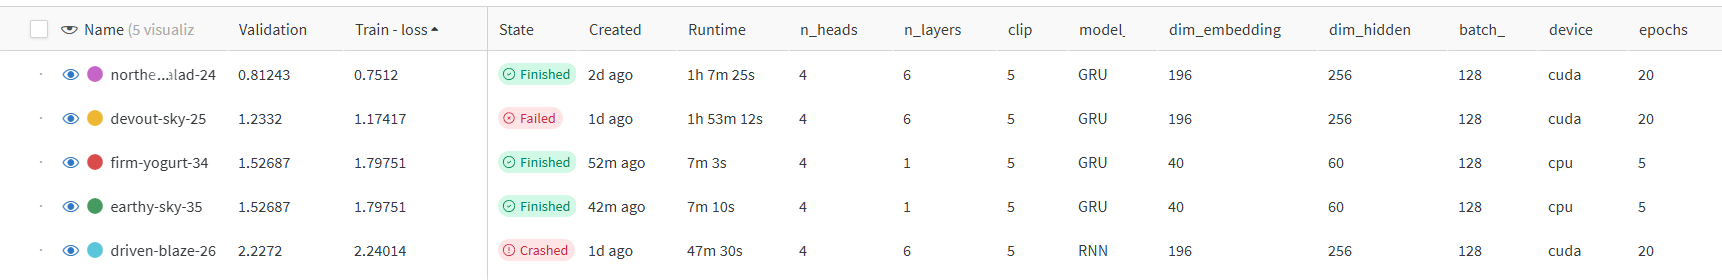

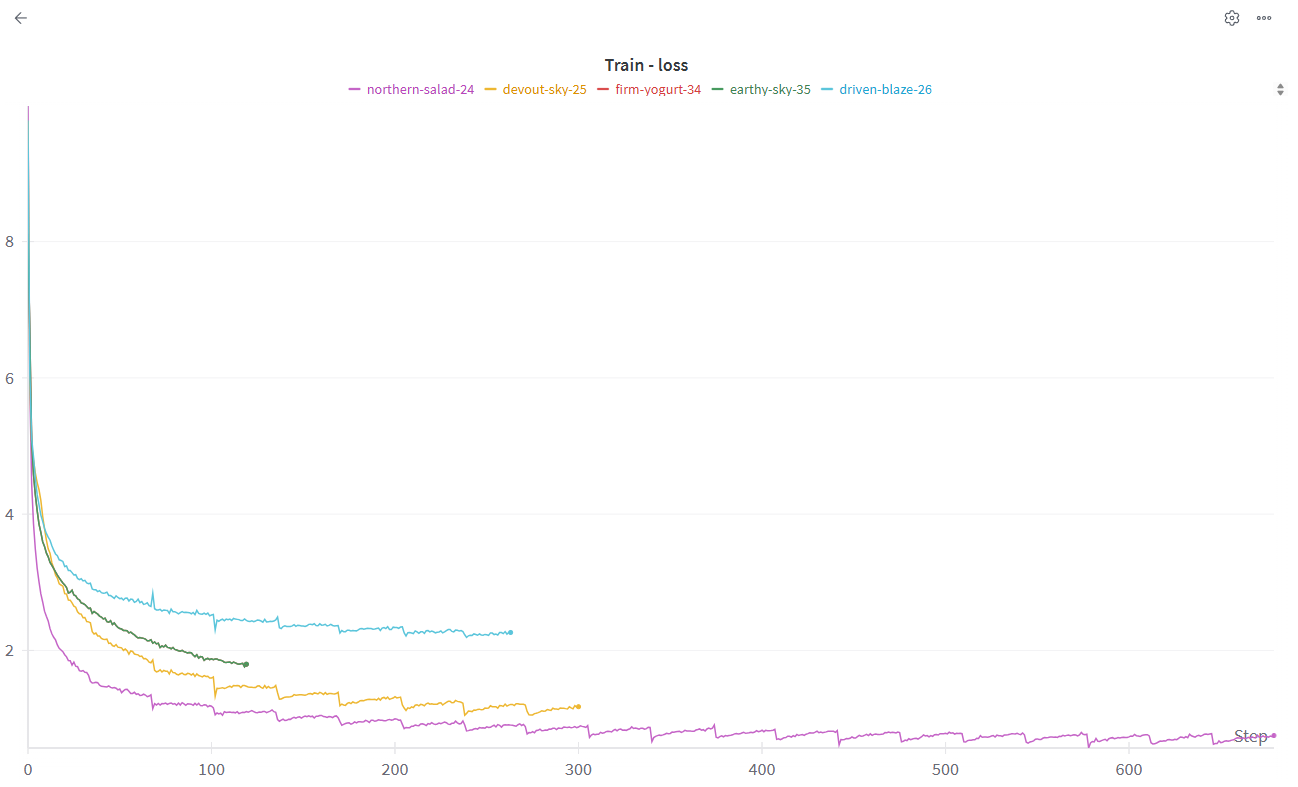
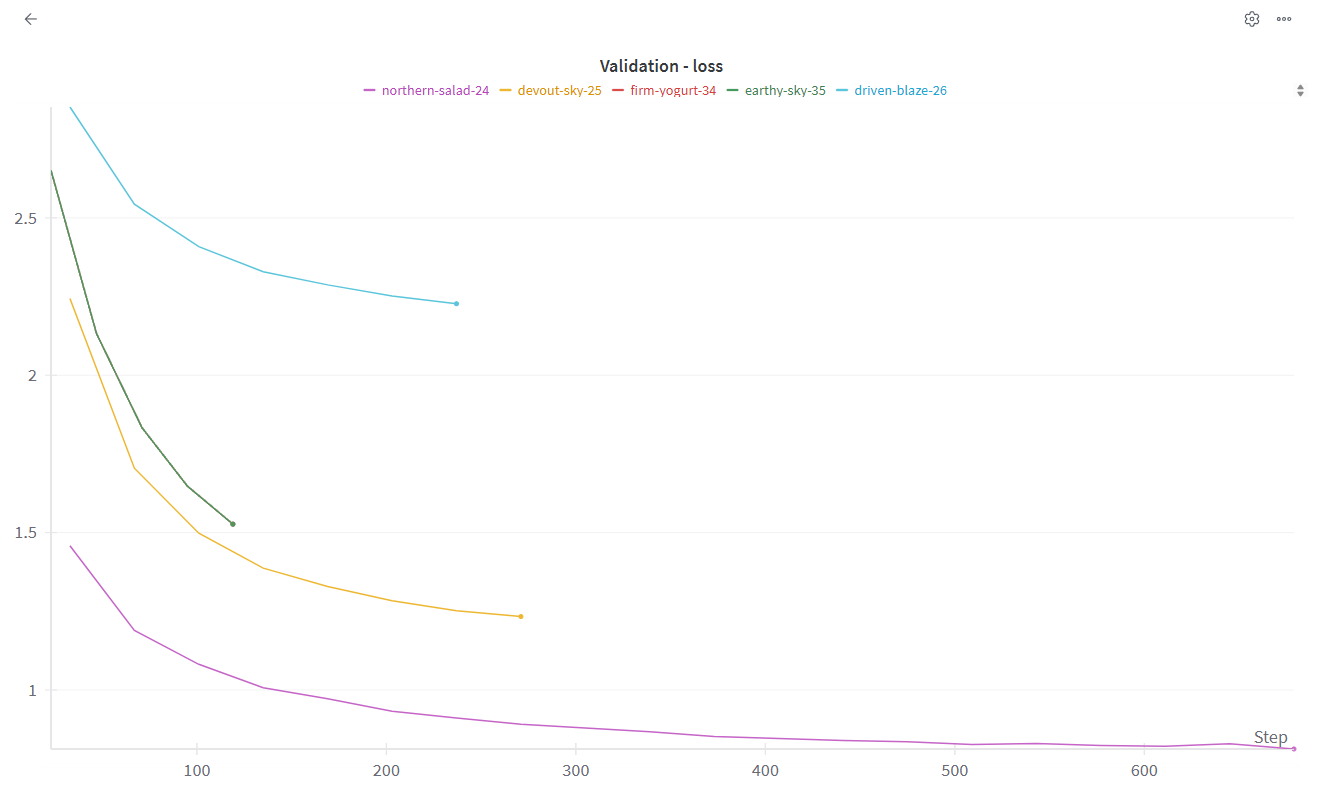

# Grading:

# Implementations (50 points total)

10 Points for your implementation of the GRU

40 Points for your implementaiton of the Transformer components

# Questions (12 points, 1 point each)
1. Explain the differences between Vanilla RNN, GRU-RNN, Encoder-Decoder Transformer and Decoder-Only Transformer.

	<font color="cyan">

	Vanilla RNN : Ceci est le modèle de base. On utilise une boucle afin de traiter une sequence à l'entrée pour créer les embedding. À chaque étape, on reprendre la sortie du layer précédent pour généré notre prochain état. On y utiliser un TranslationRNN afin de faire l'apprentissage.

	GRU-RNN (Gated Recurrent Unit) : Le GRU-RNN est une amélioration du modèle RNN. Le déroulement est très similaire à Vanilla RNN, mais on y applique un apprentissage sur l'information du passé à savoir si on veut garder certaines parties de cette information ou si on veut en enlever certaines parties. On y utilise aussi un TranslationRNN afin de faire l'apprentissage.

	Encoder-Decoder Transformer : Ce modèle utilise un mécanisme de Self-Attention pour donner un impact sur notre entrée. L'encodeur traite la séquence en entrée et génère des représentations du contexte. Cette représentation est envoyé au décodeur afin de généré la prédiction. Ce modèle est surtout utilisé pour faire des résumés ou faire une traduction.

	Decoder-Only Transformer : Comparativement au Encoder-Decoder Transformer, on n'utilise que le Docoder afin de généré notre prédiction. En utilisant toujours le mécanisme de Self-Attention, on utilise un masque causal pour s'assurer de ne pas pouvoir voir les futurs tokens.

	</font>

2. Why is positionnal encoding necessary in Transformers and not in RNNs?

	<font color="cyan">

	Les Transformeurs traitent l'information de l'ensemble des mots en même temps. Celui-ci a donc besoin de savoir l'ordre des mots entrées afin de bien pouvoir générer sa prédiction. Du côté des RNN, sa génération est faite de manière itérative. De ce fait, chaque mot est pris en compte l'un après l'autre, ce qui ne nécessite donc pas de transformer l'information avec la position. 

	</font>

3. Describe the preprocessing process. Detail how the initial dataset is processed before being fed to the translation models.

	<font color="cyan">

	Le pré-traitement est une étape importante pour nos modèles. On utilise un dictionnaire pour obtenir l'ensemble des mots possible ainsi que quelques librairies d'aide pour la génération des tokens par exemple. Nous débutons tout d'abords par filtrer les phrases afin de ne prendre que ceux d'une longueur inférieur à une longueur donnée ainsi que d'enlever certains caractère comme les sauts de ligne. Ensuite, on génère nos deux dictionnaires de token en français et en anglais pour la traduction. Par la suite, on prend une phrase à traduire. On y ajoute des tokens de début et de fin de phrase afin de bien informer la position au modèle. On transforme ensuite chaque mot en token afin de pouvoir l'envoyer dans notre modèle. 

	</font>

4. What is teacher forcing, and how is it used in Transformer training? How does the decoder input differ?

	<font color="cyan">

	Le teacher forcing est le fait d'envoyer la vraie sortie dans le décodeur pendant l'entraînement afin d'accélérer la convergence du modèle vers la solution. Cependant, cela crée une dépendance aux données parfaite et laisse moins de place à l'interprétation. Le décodeur reçoit ainsi la vraie séquence cible décalée. 

	</font>

5. How are the two types of mask important to the attention mechanism (causal and padding) and how do they work? How do they differ between the encoder and decoder?

	<font color="cyan">

	Le padding mask est utilisé pour pouvoir avoir une normalisation des longueurs de phrase. Comme les phrases ne sont pas de même longueurs, nous devons ajouter des tokens pour remplir les phrases (padding) afin de les envoyer au modèle avec la même taille. Il est donc utilisé pendant l'encodage et le décodage, mais ne doit donc pas être pris en compte pour l'apprentissage. Il y a donc un masque pour les enlever pour l'apprentissage des poids.

	Le causal mask est utilisé uniquement pour le décodeur. Cela permet de restreindre l'attention pour ne lui permettre de voir que des mots passés ou le mot actuel et de ne pas lui faire voir les mots futurs.

	</font>

6. What is a causal mask, and why is it only used in the decoder?

	<font color="cyan">

	Comme l'encodeur traîte l'ensemble de la phrase en même temps, il n'a donc pas besoin de restreindre l'accès au token futur. Cependant, le décodeur traîte ceux-ci un par un. On doit donc lui appliquer un masque afin de ne pas lui faire voir les tokens futurs pour éviter les fuites de mémoire du modèle. 

	</font>

7. Why does the decoder use both self-attention and encoder-decoder attention?

	<font color="cyan">

	Le Self-Attention permet de capture les relations entre les mots alors que le Encoder-Decoder Attention permet de capturer le mots importants de l'entrée pour alligner la sortie. L'encodeur génère cette deuxième attention en utilisant le Self-Attention. De son côté, le décodeur utilise cette information pour mieux aligner sa prédction avec l'entrée obtenu.

	</font>

8. Why is the Transformer model parallelizable, and how does this improve efficiency compared to RNNs?

	<font color="cyan">

	Les RNNs traîtent les séquences de manière itératives. Il n'est donc pas possible de parraléliser l'exécution car une étape doit nécessairement avoir besoin des précédente. Du côté des Transformer, on utilise un encodage de positionnement pour l'entrée tout en utilisant l'ensemble de la séquence pour l'apprentissage. Cela permet donc ainsi de l'exécuter sur plusieurs machines en même temps. L'exécution est donc grandement réduite dû au fait que nous utilisons la puissante de plusieurs machines combinées plutôt que d'être restreint à la puissance d'une seule machine.

	</font>

9. How does multi-head self-attention allow the model to capture different aspects of a sentence?

	<font color="cyan">

	Chaque tête du multi-head self attention peut être comparé à une neuronne. On y apprend un type d'aspects de la phrase comme la synthaxe ou les relations sémentique longue distance. Ceci permet donc d'avoir une meilleure structure de phrase et de bien reproduire ces aspects dans notre prédiction.

	</font>

10. What does the decoder's final output represent before the projection layer? What does the encoder's final output represent?

	<font color="cyan">

	Pour l'encodeur, sa dernière couche envoit un ensemble de vecteur représentant chaque token qui sont enrichis par le contexte (attention).

	Pour le décodeur, il produit un vecteur représentant chaque token généré avant la phase de projection qui calcule les probabilités sur le vocabulaire.

	</font>

11. What is the role of the final linear projection layer in the decoder? How does the decoder output differ between training (parallel processing) and inference (sequential generation)?

	<font color="cyan">

	Le rôle de la dernier projection linéaire du décodeur est de convertir les embeddings de ce dernier en score de probabilité sur le vocbulaire (avec le softmax). On veut donc convertir notre apprentissage à un language plus lisible pour un humain.
	
	Pendant l'entraînement, le modèle génère sa sortie en une seule phase de manière parallèle. On y utiliser un masque causal afin de masquer les tokens futurs.
	
	Pendant l'inférence, le modèle n'a pas accès à l'ensemble de la séquence. Il génère ses tokens un par un en utilisant les précédants comme input pour le prochain. Il refait ses prédictions avec une séquence étendue jusqu'à ce que la phrase soit complètement faite ou qu'elle ait atteint la longueur maximale.

	</font>

12. Why does the decoder recompute all outputs at each inference step instead of appending new outputs incrementally?

	<font color="cyan">

	Les décodeurs n'a pas de mémoire de session contrairement aux RNNs. Pendant la phase d'inférence, le décodeurs réévalue l'entièreté de la séquence avec les tokens précédents pour générer sa prédiction afin de garantir une meilleure consistance. Cependant, cela alourdi énormément le temps de calcul. 

	</font>


# Small report - experiments of your own choice (15 points)
Once everything is working fine, you can explore aspects of these models and do some research of your own into how they behave.

For exemple, you can experiment with the hyperparameters.
What are the effect of the differents hyperparameters with the final model performance? What about training time? If you decide to implement Greedy search to compare with beam search, how much worse is it ?

What are some other metrics you could have for machine translation? Can you compute them and add them to your WandB report?

Those are only examples, you can do whatever you think will be interesting.
This part accounts for many points, *feel free to go wild!*

---
*Make a concise report about your experiments here.*

<font color="cyan">
En ce qui concerne les hyperparamètres, j'ai pu testé avec plusieurs layers et plusiers n_heads. Le paramètre de layers sert à augmenter le nombre de couche de neuronne, ce qui augmente la précision des caractéristiques apprises. On peut d'ailleurs y voir de meilleurs résultats entre 1 layers et 3 layers. Pour ce qui est du n_heads, elle s'occupe de nombre de head pour le multi-head self-attention. Les heads apportent une meilleure compréhension des caractéristiques d'une phrase, ce qui en fait qu'en avoir plus est mieux. Cependant, ces 2 paramètres joue un très grand rôle dans le temps d'exécution de l'algorithme. De ce fait, je n'ai pas pu beaucoup testé avec de nombreuse données vu le temps d'exécution réduit que nous avons.

Du côté de Beam_Search et Greedy_Search, ces deux méthodes sont assez similaire. Le Greedy_Search prend toujours les tokens avec la meilleure probabilité afin de donnée sont résultat. On y enchaîne un par un jusqu'à obtenir la phrase complète. Du côté du Beam_Search, on lui donne une certaines fenêtres afin de capturer plus de possibilités pour ne pas tomber dans des minimum locaux. On va donc garder un certains nombre de probabilités pour s'assurer de ne pas avoir un minimum locaux des le premier token et ne plus pouvoir obtenir la bonne solution. Cependant, ce dernier est moins utile lorsque notre précision est assez forte, ce qui est le cas de l'exemple que j'ai eu.

Voici le résultat pour un Greedy Search :

0. (1.66262%) 	 c'est possible pour votre travail ici.'


Et voici les résultats pour un Beam Search : 

0. (1.66262%) 	 c'est possible pour votre travail ici.
1. (1.12823%) 	 c'est possible pour ton travail ici.
2. (0.94957%) 	 c'est possible de ton travail ici.
3. (0.80045%) 	 c'est possible de votre travail ici.
4. (0.59901%) 	 c'est possible pour votre travail.

On peu ainsi y voir que les résultats sont assez similaire et qu'il ne vaudrait pas grand chose d'utiliser le Beam Search. Cependant, il y a eu beaucoup d'importance dans cette phrase pour les mots "possible" et "travail" dans cette phrase, ce qui a causé un impact.
</font>

---
# Not Part of TP3, But A Potential Project Idea: Understanding the Architecture of a Decoder-Only Transformer

Step 1: In a project group of 3-4 create a high level plan for a Decoder-Only model for how you would need to modify this code to implement a Decoder-Only Transformer. Key components of the implementation should be split up and each member of the group should present the pseudo-code (or actual code) for one component of the full model to one another, and in a report. Then create the working model and perform experiments comparing it with your TP3 encoder-decoder model.

For more details on the Decoder-Only Transformer see [this blog post](https://medium.com/international-school-of-ai-data-science/building-custom-gpt-with-pytorch-59e5ba8102d4). The [first "GPT" paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), and the paper cited by this GPT-1 paper for the Decoder Only architecture used for GPT, [i.e. this paper](https://arxiv.org/abs/1801.10198)